In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
df = pd.read_csv('ex4_train.csv', index_col=0)

In [23]:
y_train = df.iloc[:,400]
x_train = df.iloc[:,0:400]

In [24]:
x_train = np.matrix(x_train)
y_train = np.matrix(y_train).T

In [25]:
indices = y_train
depth = 10
a = tf.one_hot(indices, depth, on_value = 1.0, off_value = 0.0, axis=1)

In [26]:
sess = tf.Session()
y_train_encoded = sess.run(a)

In [27]:
y_train_encoded = np.matrix(y_train_encoded)

In [28]:
df1 = pd.read_csv('ex4_test.csv', index_col=0)

In [29]:
y_test = df1.iloc[:,400]
x_test = df1.iloc[:,0:400]
x_test = np.matrix(x_test)
y_test = np.matrix(y_test).T
indices = y_test
depth = 10
b = tf.one_hot(indices, depth, on_value = 1.0, off_value = 0.0, axis=1)
sess = tf.Session()
y_test_encoded = sess.run(b)
y_test_encoded = np.matrix(y_test_encoded)

In [30]:
def accuracy(predictions, labels):
#     return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])
    correct = [1 if a == b else 0 for (a, b) in zip(np.array(labels), predictions)]  
    accuracy = (float(sum(map(int, correct))) / float(len(correct)))  
    return accuracy * 100

__Define Functions, neural network model and predictions__
- Because of the structure of tensorflow, I defined all functions (built-in by TensorFlow) in one graph and use those functions to build a model in the same graph

In [31]:
hidden_nodes_1 = 150
hidden_nodes_2 = 50
graph = tf.Graph()
with graph.as_default():
    tf_train_data = tf.placeholder(dtype=tf.float32, shape=(x_train.shape[0], x_train.shape[1]))
    tf_train_labels = tf.placeholder(dtype=tf.float32, shape=(y_train_encoded.shape[0], y_train_encoded.shape[1]))
    tf_test_data = tf.constant(x_test, dtype=tf.float32)
    initializers = tf.contrib.layers.xavier_initializer(seed=1, dtype=tf.float32)
    weights_1 = tf.Variable(initializers([x_train.shape[1], hidden_nodes_1]))
    bias_1 = tf.Variable(tf.zeros([hidden_nodes_1], dtype=tf.float32))
    weights_2 = tf.Variable(initializers([hidden_nodes_1,hidden_nodes_2]))
    bias_2 = tf.Variable(tf.zeros([hidden_nodes_2]))
    weights_3 = tf.Variable(initializers([hidden_nodes_2, 10]))
    bias_3 = tf.Variable(tf.zeros([10]))
    
    logits_1 = tf.matmul(tf_train_data, weights_1) + bias_1
    activation_1 = tf.nn.relu(logits_1)
    keep_prob = tf.placeholder(tf.float32)
    layer_1_dropout = tf.nn.dropout(activation_1, keep_prob)
    
    logits_2 = tf.matmul(layer_1_dropout, weights_2) + bias_2
    activation_2 = tf.nn.relu(logits_2)
    layer_2_dropout = tf.nn.dropout(activation_2, keep_prob)
    
    logits_3 = tf.matmul(layer_2_dropout, weights_3) + bias_3
    activation_3 = tf.sigmoid(logits_3)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = activation_3, labels = tf_train_labels))
    
    global_step = tf.Variable(0)
    
    starting_learning_rate = 0.001
    #learning_rate = tf.train.exponential_decay(starting_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(starting_learning_rate).minimize(cost, global_step = global_step)
    
    train_predictions = tf.argmax(tf.nn.softmax(activation_3), axis=1)
    
    logits_test_1 = tf.matmul(tf_test_data, weights_1) + bias_1
    activation_test_1 = tf.nn.relu(logits_test_1)
    
    logits_test_2 = tf.matmul(activation_test_1, weights_2) + bias_2
    activation_test_2 = tf.nn.relu(logits_test_2)
    
    
    logits_test_3 = tf.matmul(activation_test_2, weights_3) + bias_3
    activation_test_3 = tf.nn.sigmoid(logits_test_3)
    test_prediction = tf.argmax(tf.nn.softmax(logits_test_3), axis=1)

- The data has been splitted so I took the whole train set for training to improve the accuracy and test with the test set
- Predictions is made right after the training process for each iterations to calculate cost and accuracy

In [32]:
train_accuracies = []
test_accuracies = []

In [33]:
num_steps = 1500
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print "Initialized"
    #k = tf.convert_to_tensor(keep_prob[0], dtype=np.float32)
    #k = keep_prob[0]
#     keep_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     keep_prob = np.matrix(keep_prob).T
    #keep_probs = tf.constant(keep_prob, dtype = tf.float32)
    for step in range(num_steps):
        feed_dict = {tf_train_data: x_train, tf_train_labels:y_train_encoded, keep_prob:0.2}
        _,c, predictions = session.run([optimizer, cost, train_predictions], feed_dict=feed_dict)
        if (step % 500 ==0):
            print("Cost at step {}: {}".format(step,c))
            a = accuracy(predictions, y_train)
            print("Accuracy training set: {:,.1f}".format(a))
#             print "Predictions:"
#             print type(predictions)
    train_accuracies.append(a)
    t = accuracy(test_prediction.eval(), y_test)
    print("Accuracy test set:{:,.1f}".format(t))
    test_accuracies.append(t)

Initialized
Cost at step 0: 2.3411796093
Accuracy training set: 9.3
Cost at step 500: 1.68450772762
Accuracy training set: 72.3
Cost at step 1000: 1.62838160992
Accuracy training set: 77.7
Accuracy test set:91.5


In [34]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print "Initialized"
    #k = tf.convert_to_tensor(keep_prob[0], dtype=np.float32)
    #k = keep_prob[0]
#     keep_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     keep_prob = np.matrix(keep_prob).T
    #keep_probs = tf.constant(keep_prob, dtype = tf.float32)
    for step in range(num_steps):
        feed_dict = {tf_train_data: x_train, tf_train_labels:y_train_encoded, keep_prob:0.3}
        _,c, predictions = session.run([optimizer, cost, train_predictions], feed_dict=feed_dict)
        if (step % 500 ==0):
            print("Cost at step {}: {}".format(step,c))
            a = accuracy(predictions, y_train)
            print("Accuracy training set: {:,.1f}".format(a))
#             print "Predictions:"
#             print type(predictions)
    train_accuracies.append(a)
    t = accuracy(test_prediction.eval(), y_test)
    print("Accuracy test set:{:,.1f}".format(t))
    test_accuracies.append(t)

Initialized
Cost at step 0: 2.3242957592
Accuracy training set: 9.9
Cost at step 500: 1.5914927721
Accuracy training set: 87.3
Cost at step 1000: 1.54493260384
Accuracy training set: 90.9
Accuracy test set:92.3


In [35]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print "Initialized"
    #k = tf.convert_to_tensor(keep_prob[0], dtype=np.float32)
    #k = keep_prob[0]
#     keep_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     keep_prob = np.matrix(keep_prob).T
    #keep_probs = tf.constant(keep_prob, dtype = tf.float32)
    for step in range(num_steps):
        feed_dict = {tf_train_data: x_train, tf_train_labels:y_train_encoded, keep_prob:0.5}
        _,c, predictions = session.run([optimizer, cost, train_predictions], feed_dict=feed_dict)
        if (step % 500 ==0):
            print("Cost at step {}: {}".format(step,c))
            a = accuracy(predictions, y_train)
            print("Accuracy training set: {:,.1f}".format(a))
#             print "Predictions:"
#             print type(predictions)
    train_accuracies.append(a)
    t = accuracy(test_prediction.eval(), y_test)
    print("Accuracy test set:{:,.1f}".format(t))
    test_accuracies.append(t)

Initialized
Cost at step 0: 2.31321048737
Accuracy training set: 9.6
Cost at step 500: 1.51798522472
Accuracy training set: 95.4
Cost at step 1000: 1.49210882187
Accuracy training set: 97.6
Accuracy test set:93.7


In [36]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print "Initialized"
    #k = tf.convert_to_tensor(keep_prob[0], dtype=np.float32)
    #k = keep_prob[0]
#     keep_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     keep_prob = np.matrix(keep_prob).T
    #keep_probs = tf.constant(keep_prob, dtype = tf.float32)
    for step in range(num_steps):
        feed_dict = {tf_train_data: x_train, tf_train_labels:y_train_encoded, keep_prob:0.7}
        _,c, predictions = session.run([optimizer, cost, train_predictions], feed_dict=feed_dict)
        if (step % 500 ==0):
            print("Cost at step {}: {}".format(step,c))
            a = accuracy(predictions, y_train)
            print("Accuracy training set: {:,.1f}".format(a))
#             print "Predictions:"
#             print type(predictions)
    train_accuracies.append(a)
    t = accuracy(test_prediction.eval(), y_test)
    print("Accuracy test set:{:,.1f}".format(t))
    test_accuracies.append(t)

Initialized
Cost at step 0: 2.31097865105
Accuracy training set: 10.5
Cost at step 500: 1.49243724346
Accuracy training set: 97.6
Cost at step 1000: 1.4751598835
Accuracy training set: 99.1
Accuracy test set:94.3


In [37]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print "Initialized"
    #k = tf.convert_to_tensor(keep_prob[0], dtype=np.float32)
    #k = keep_prob[0]
#     keep_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     keep_prob = np.matrix(keep_prob).T
    #keep_probs = tf.constant(keep_prob, dtype = tf.float32)
    for step in range(num_steps):
        feed_dict = {tf_train_data: x_train, tf_train_labels:y_train_encoded, keep_prob:0.8}
        _,c, predictions = session.run([optimizer, cost, train_predictions], feed_dict=feed_dict)
        if (step % 500 ==0):
            print("Cost at step {}: {}".format(step,c))
            a = accuracy(predictions, y_train)
            print("Accuracy training set: {:,.1f}".format(a))
#             print "Predictions:"
#             print type(predictions)
    train_accuracies.append(a)
    t = accuracy(test_prediction.eval(), y_test)
    print("Accuracy test set:{:,.1f}".format(t))
    test_accuracies.append(t)

Initialized
Cost at step 0: 2.30977797508
Accuracy training set: 10.0
Cost at step 500: 1.4860714674
Accuracy training set: 98.0
Cost at step 1000: 1.47244811058
Accuracy training set: 99.1
Accuracy test set:94.3


In [38]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print "Initialized"
    #k = tf.convert_to_tensor(keep_prob[0], dtype=np.float32)
    #k = keep_prob[0]
#     keep_prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     keep_prob = np.matrix(keep_prob).T
    #keep_probs = tf.constant(keep_prob, dtype = tf.float32)
    for step in range(num_steps):
        feed_dict = {tf_train_data: x_train, tf_train_labels:y_train_encoded, keep_prob:0.9}
        _,c, predictions = session.run([optimizer, cost, train_predictions], feed_dict=feed_dict)
        if (step % 500 ==0):
            print("Cost at step {}: {}".format(step,c))
            a = accuracy(predictions, y_train)
            print("Accuracy training set: {:,.1f}".format(a))
#             print "Predictions:"
#             print type(predictions)
    train_accuracies.append(a)
    t = accuracy(test_prediction.eval(), y_test)
    print("Accuracy test set:{:,.1f}".format(t))
    test_accuracies.append(t)

Initialized
Cost at step 0: 2.31002449989
Accuracy training set: 11.1
Cost at step 500: 1.47906553745
Accuracy training set: 98.7
Cost at step 1000: 1.47021794319
Accuracy training set: 99.3
Accuracy test set:94.4


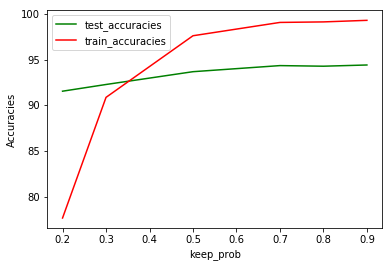

In [39]:
keep_prob = [0.2,0.3, 0.5, 0.7, 0.8, 0.9]
plt.plot(keep_prob,test_accuracies, color='green')
plt.plot(keep_prob,train_accuracies, color='red')
plt.legend(['test_accuracies', 'train_accuracies'], loc='upper left')
plt.xlabel('keep_prob')
plt.ylabel('Accuracies')
plt.show()

In [57]:
def topKFrequent(nums, k):
        """
        :type nums: List[int]
        :type k: int
        :rtype: List[int]
        """
        results = []
        counts = []
        count = 1
        nums_sorted = sorted(nums)
        for i in range(0, len(nums_sorted)):
            for j in range(1, len(nums)):
                if (nums_sorted[i] == nums_sorted[j] and nums_sorted[i] != nums_sorted[i - 1]):
                    count = count + 1
            counts.append(count)
            count = 1
                    
        #counts.sort()
        print counts
        print nums[5]
        print [i for i, j in enumerate(counts) if j == max(counts)]
        for j in range(0, k):
            if counts
            results.append(nums[len(counts) - j -1])
        return results

In [58]:
results = topKFrequent([1,1,1,2,2,3], 2)

[3, 1, 1, 3, 1, 2]
3
[0, 3]


In [48]:
results

[3, 2]